C:\Users\Hema\AppData\Local\Temp\ipykernel_2424\385784366.py:25: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')



Suspicious logins:
              timestamp username       ip   result
931 2025-07-18 07:01:11  unknown  unknown  Failure
927 2025-07-18 07:01:17  unknown  unknown  Failure
926 2025-07-18 07:01:17  unknown  unknown  Failure
917 2025-07-18 07:01:19  unknown  unknown  Failure
915 2025-07-18 07:01:20  unknown  unknown  Failure
916 2025-07-18 07:01:20  unknown  unknown  Failure
914 2025-07-18 07:01:20  unknown  unknown  Failure
913 2025-07-18 07:01:21  unknown  unknown  Failure
912 2025-07-18 07:01:21  unknown  unknown  Failure
911 2025-07-18 07:01:48  unknown  unknown  Failure
910 2025-07-18 07:03:04  unknown  unknown  Failure
909 2025-07-18 07:03:20  unknown  unknown  Failure
908 2025-07-18 07:03:20  unknown  unknown  Failure
907 2025-07-18 07:03:20  unknown  unknown  Failure
906 2025-07-18 07:03:21  unknown  unknown  Failure
905 2025-07-18 07:03:21  unknown  unknown  Failure
904 2025-07-18 07:05:07  unknown  unknown  Failure
682 2025-07-18 22:52:34  unknown  unknown  Failure
681 2025-07

C:\Users\Hema\AppData\Local\Temp\ipykernel_2424\385784366.py:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('timestamp').resample('1H').size().plot(title='Login Attempts Over Time')


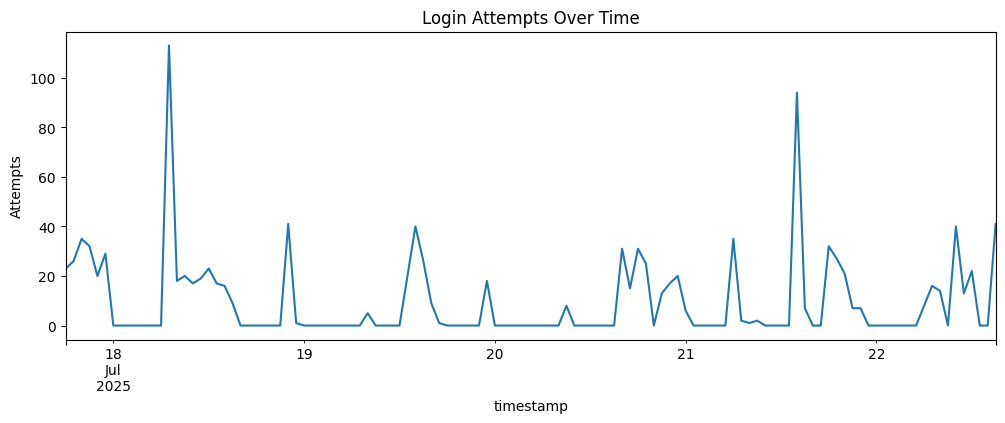

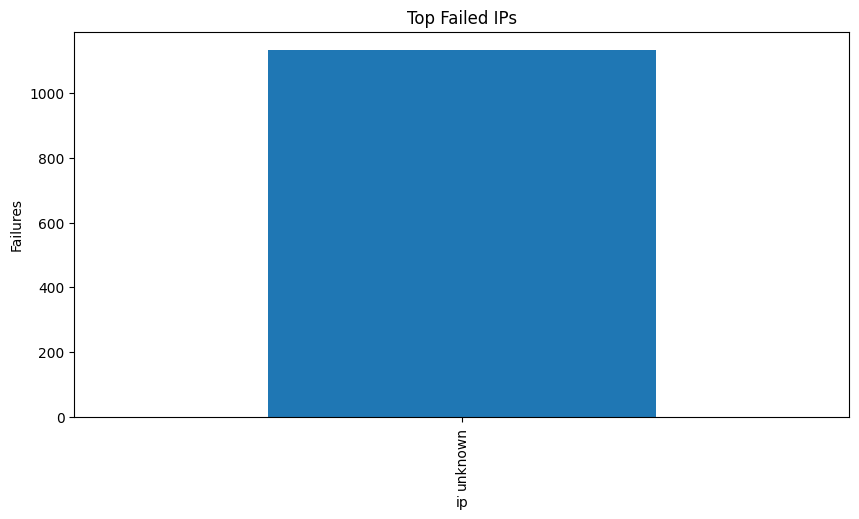

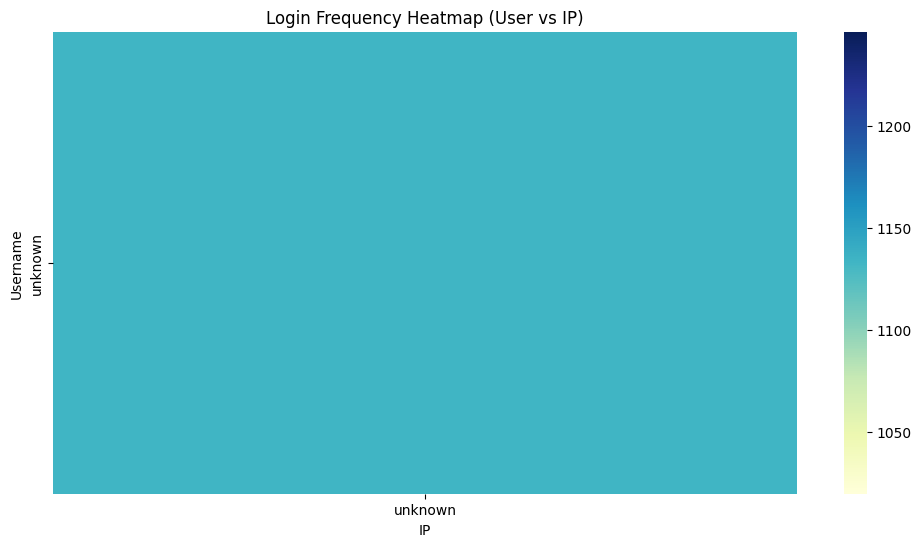

In [2]:
import pandas as pd
import re
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Parse Log File and extract relevant fields
def parse_logs(csv_path):
    df_raw = pd.read_csv(csv_path, engine='python')
    
    def extract_fields(msg):
        username = re.search(r'Account Name:\s+([^\s\\]+)', msg)
        ip = re.search(r'Network Address:\s+([\d.]+)', msg)
        result = "Success" if "An account was successfully logged on" in msg else "Failure"
        return pd.Series({
            "username": username.group(1) if username else "unknown",
            "ip": ip.group(1) if ip else "unknown",
            "result": result
        })

    df_fields = df_raw['TaskDisplayName'].apply(extract_fields)
    df = pd.concat([df_raw, df_fields], axis=1)
    df.rename(columns={'TimeCreated': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['timestamp'], inplace=True)
    return df[['timestamp', 'username', 'ip', 'result']]

# Step 2: Feature Engineering
def feature_engineering(df):
    df = df.sort_values(by='timestamp')
    df['failed_by_ip_5min'] = 0
    df['user_logins_5min'] = 0
    df['is_new_ip'] = 0
    df['success_rate_ip'] = 0.0
    ip_history = {}
    user_ip_set = {}

    for i, row in df.iterrows():
        current_time = row['timestamp']
        ip = row['ip']
        user = row['username']

        past_5min = df[(df['timestamp'] >= current_time - timedelta(minutes=5)) & (df['timestamp'] < current_time)]
        df.at[i, 'failed_by_ip_5min'] = len(past_5min[(past_5min['ip'] == ip) & (past_5min['result'] == 'Failure')])
        df.at[i, 'user_logins_5min'] = len(past_5min[past_5min['username'] == user])

        # Is new IP for user
        if user not in user_ip_set:
            user_ip_set[user] = set()
        df.at[i, 'is_new_ip'] = 1 if ip not in user_ip_set[user] else 0
        user_ip_set[user].add(ip)

        # Success rate
        if ip not in ip_history:
            ip_history[ip] = {'success': 0, 'total': 0}
        rate = ip_history[ip]['success'] / ip_history[ip]['total'] if ip_history[ip]['total'] > 0 else 1
        df.at[i, 'success_rate_ip'] = rate
        ip_history[ip]['total'] += 1
        if row['result'] == 'Success':
            ip_history[ip]['success'] += 1

    return df

# Step 3: Train Anomaly Detection Model
def train_anomaly_model(df):
    features = df[['failed_by_ip_5min', 'user_logins_5min', 'is_new_ip', 'success_rate_ip']]
    model = IsolationForest(contamination=0.05, random_state=42)
    df['anomaly'] = model.fit_predict(features)
    return df

# Step 4: Flag Suspicious Logins
def flag_suspicious(df):
    suspicious = df[df['anomaly'] == -1]
    print("\nSuspicious logins:")
    print(suspicious[['timestamp', 'username', 'ip', 'result']])

    print("\nSuspicious by IP:")
    print(suspicious['ip'].value_counts())

    print("\nSuspicious by User:")
    print(suspicious['username'].value_counts())
    return suspicious

# Step 5: Visualization
def visualize(df):
    plt.figure(figsize=(12, 4))
    df.set_index('timestamp').resample('1H').size().plot(title='Login Attempts Over Time')
    plt.ylabel('Attempts')
    plt.show()

    plt.figure(figsize=(10, 5))
    df[df['result'] == 'Failure']['ip'].value_counts().head(10).plot(kind='bar', title='Top Failed IPs')
    plt.ylabel('Failures')
    plt.show()

    heatmap_data = pd.crosstab(df['username'], df['ip'])
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True)
    plt.title("Login Frequency Heatmap (User vs IP)")
    plt.xlabel("IP")
    plt.ylabel("Username")
    plt.show()

# Main function
def main(csv_path):
    df = parse_logs(csv_path)
    df = feature_engineering(df)
    df = train_anomaly_model(df)
    suspicious = flag_suspicious(df)
    visualize(df)

# Run the system
if __name__ == "__main__":
    main("login_logs.csv")  # Replace with your actual log file
